In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd

import rioxarray as rxr
import geopandas as gpd

import pylandstats as pls
from src.demo.plot_settings import ps_defaults, set_dim
ps_defaults(use_tex=True)

from src.geograph import GeoGraph
from src.geotimeline import TimedGeoGraph, GeoGraphTimeline
from src.constants import DATA_DIR, UTM35N, ROIS

# Parse geotif landcover data
chernobyl_path = lambda year: DATA_DIR / "chernobyl" / "esa_cci" / f"esa_cci_{year}_chernobyl.tif" 

# Parse ROIS
rois = gpd.read_file(ROIS)
cez = rois[rois["name"] == "Chernobyl Exclusion Zone"]
ez = rois[rois.name.str.contains("Exclusion")]

## 2. Load Chernobyl Exclusion Zone data

In [3]:
def clip_and_reproject(xrdata, clip_geometry=None, to_crs=UTM35N, x_res=300, y_res=300):
    
    if clip_geometry is not None:
        clipped_data = xrdata.rio.clip(clip_geometry)
    else:
        clipped_data = xrdata
        
    if to_crs is not None:
        reprojected_data = clipped_data.rio.reproject(to_crs, resolution=(x_res, y_res))
    else:
        reprojected_data = clipped_data
    
    return reprojected_data

In [4]:
# Loading raster data
years = list(range(2000,2015))
cez_rasters = {year: clip_and_reproject(rxr.open_rasterio(chernobyl_path(year)), clip_geometry=cez.geometry) 
              for year in years
             }

In [5]:
## NOTE: For faster loading you can load the graphs from memory.
#        The demo path includes pre-loaded graphs for faster loading. Simply uncomment.
#demo_path = DATA_DIR / "chernobyl" / "graphs"
#years = list(range(2000,2015))
#cez_graphs = {year: GeoGraph(chernobyl_path(yera))
#              for year in years}

# Polygonising raster and transforming into graph
cez_graphs = {}
for year, raster in cez_rasters.items():
    print(f"Analysing year {year}")
    # Load geograph from the raster data (construction takes ~5s)
    cez_graphs[year] = GeoGraph(data=raster.data.squeeze(), 
                                transform=raster.rio.transform(), 
                                mask = raster.data.squeeze() > 0,
                                crs=UTM35N, 
                                connectivity=8)

Analysing year 2000


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1924/1924 [00:01<00:00, 1425.51it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1924/1924 [00:00<00:00, 67463.43it/s]


Graph successfully loaded with 1924 nodes and 4912 edges.
Analysing year 2001


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1931/1931 [00:01<00:00, 1439.89it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1931/1931 [00:00<00:00, 54821.01it/s]


Graph successfully loaded with 1931 nodes and 4918 edges.
Analysing year 2002


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1929/1929 [00:01<00:00, 1413.43it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1929/1929 [00:00<00:00, 61787.40it/s]


Graph successfully loaded with 1929 nodes and 4897 edges.
Analysing year 2003


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1936/1936 [00:01<00:00, 1255.91it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1936/1936 [00:00<00:00, 64933.85it/s]


Graph successfully loaded with 1936 nodes and 4911 edges.
Analysing year 2004


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1953/1953 [00:01<00:00, 1082.23it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1953/1953 [00:00<00:00, 50851.88it/s]


Graph successfully loaded with 1953 nodes and 4953 edges.
Analysing year 2005


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1960/1960 [00:01<00:00, 1202.18it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1960/1960 [00:00<00:00, 58944.24it/s]


Graph successfully loaded with 1960 nodes and 4973 edges.
Analysing year 2006


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 2004/2004 [00:01<00:00, 1136.57it/s]
Step 2 of 2: Adding edges: 100%|██████████| 2004/2004 [00:00<00:00, 61635.71it/s]


Graph successfully loaded with 2004 nodes and 5113 edges.
Analysing year 2007


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1996/1996 [00:01<00:00, 1206.78it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1996/1996 [00:00<00:00, 59821.01it/s]


Graph successfully loaded with 1996 nodes and 5141 edges.
Analysing year 2008


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1992/1992 [00:01<00:00, 1142.89it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1992/1992 [00:00<00:00, 39544.56it/s]


Graph successfully loaded with 1992 nodes and 5119 edges.
Analysing year 2009


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1994/1994 [00:01<00:00, 1236.88it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1994/1994 [00:00<00:00, 66390.22it/s]


Graph successfully loaded with 1994 nodes and 5108 edges.
Analysing year 2010


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1988/1988 [00:01<00:00, 1088.69it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1988/1988 [00:00<00:00, 50291.17it/s]


Graph successfully loaded with 1988 nodes and 5080 edges.
Analysing year 2011


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 2003/2003 [00:01<00:00, 1235.16it/s]
Step 2 of 2: Adding edges: 100%|██████████| 2003/2003 [00:00<00:00, 61921.89it/s]


Graph successfully loaded with 2003 nodes and 5131 edges.
Analysing year 2012


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1998/1998 [00:01<00:00, 1203.33it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1998/1998 [00:00<00:00, 65800.49it/s]


Graph successfully loaded with 1998 nodes and 5119 edges.
Analysing year 2013


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 2003/2003 [00:01<00:00, 1127.01it/s]
Step 2 of 2: Adding edges: 100%|██████████| 2003/2003 [00:00<00:00, 64449.54it/s]


Graph successfully loaded with 2003 nodes and 5140 edges.
Analysing year 2014


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 1999/1999 [00:01<00:00, 1169.66it/s]
Step 2 of 2: Adding edges: 100%|██████████| 1999/1999 [00:00<00:00, 65990.43it/s]

Graph successfully loaded with 1999 nodes and 5117 edges.


In [6]:
cez_timeline = GeoGraphTimeline(cez_graphs)

In [7]:
# Perform node identification between adjacent time slices (takes ~10s)
cez_timeline.timestack()

# 3. Plots

Let us now visualise the ecosystem dynamics from 2013 to 2014

In [8]:
# Identify node dynamics for the year 2014
cez_timeline.calculate_node_dynamics(2014)

node_index
0       unchanged
1       unchanged
2       unchanged
3       unchanged
4       unchanged
          ...    
1994    unchanged
1995    unchanged
1996    unchanged
1997    unchanged
1998    unchanged
Name: node_dynamic, Length: 1999, dtype: object

In [9]:
cez_timeline[2014].df.node_dynamic.unique()

array(['unchanged', 'split', 'birth', 'grew', 'shrank', 'complex',
       'merged'], dtype=object)

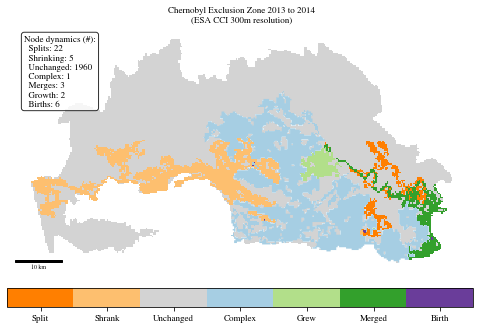

In [10]:
graph = cez_timeline[2014]

plot_scale_factor=1
dynamic_to_int = {'split': 0, 
                  'shrank': 1,
                  'unchanged': 2,
                  'complex': 3,
                  'grew': 4,
                  'merged': 5,
                  'birth': 6}

colors = sns.color_palette("Paired").as_hex()
dynamic = lambda x: dynamic_to_int[x]
graph.df["dynamic_class"] = graph.df.node_dynamic.map(dynamic)

fig, ax = plt.subplots(1)
plt.title("Chernobyl Exclusion Zone 2013 to 2014\n(ESA CCI 300m resolution)", fontsize=9*plot_scale_factor)
set_dim(fig, fraction_of_line_width=plot_scale_factor)
vmin, vmax = 0, 7
cmap = mpl.colors.ListedColormap([colors[7], colors[6], 'lightgrey', colors[0], colors[2], colors[3], colors[9]])
graph.df.plot(column='dynamic_class', cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
ax.set_xticks([])
ax.set_yticks([])

inset_text = ("Node dynamics (#):\n"
              f"  Splits: {np.sum(graph.df['node_dynamic'] == 'split')}\n"
              f"  Shrinking: {np.sum(graph.df['node_dynamic'] == 'shrank')}\n"
              f"  Unchanged: {np.sum(graph.df['node_dynamic'] == 'unchanged')}\n"
              f"  Complex: {np.sum(graph.df['node_dynamic'] == 'complex')}\n"
              f"  Merges: {np.sum(graph.df['node_dynamic'] == 'merged')}\n"
              f"  Growth: {np.sum(graph.df['node_dynamic'] == 'grew')}\n"
              f"  Births: {np.sum(graph.df['node_dynamic'] == 'birth')}"
             )

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# place a text box in upper left in axes coords
ax.text(0.03, 0.97, inset_text, transform=ax.transAxes, fontsize=9*plot_scale_factor,
        verticalalignment='top', bbox=props)

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=6*plot_scale_factor)
scalebar = AnchoredSizeBar(ax.transData,
                           1e4, '10 km', 'lower left', 
                           pad=0,
                           borderpad=.8,
                           color='black',
                           frameon=False,
                           size_vertical=250,
                           fontproperties=fontprops
                       )

ax.add_artist(scalebar)

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.12, 0.08, 0.78, 0.05]) # left-offset, # bottom offset # width, # height
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_ticks(np.arange(vmin+0.5, vmax+1))
cbar.set_ticklabels(["Split", "Shrank", "Unchanged", "Complex", "Grew", "Merged", "Birth"])
cbar.ax.tick_params(labelsize=9*plot_scale_factor) 
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)



#plt.savefig("CEZ_node_dynamics.svg")
#plt.savefig("CEZ_node_dynamics.png")

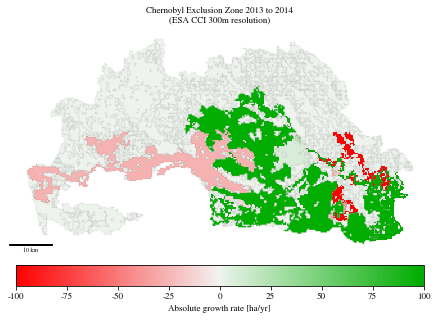

In [11]:
plot_scale_factor=1
fig, ax = plt.subplots(1)
set_dim(fig, fraction_of_line_width=plot_scale_factor)

cmap = sns.diverging_palette(6, 120, s=360, l=55, as_cmap=True)
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-10e5, vmax=10e5)

graph.df.plot("absolute_growth", ax=ax, cmap=cmap, norm=norm, edgecolor="grey", linewidth=0.1)
ax.set_xticks([])
ax.set_yticks([])
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=6*plot_scale_factor)
scalebar = AnchoredSizeBar(ax.transData,
                           1e4, '10 km', 'lower left', 
                           pad=0,
                           borderpad=.3,
                           color='black',
                           frameon=False,
                           size_vertical=250,
                           fontproperties=fontprops
                       )

ax.add_artist(scalebar)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             orientation='horizontal', 
             label='Absolute growth rate [ha / yr]',
             #aspect=9,
             shrink=0.88,
             pad=0.04
            )
cbar.set_ticks([-10e5, -7.5*1e5, -5e5, -2.5*1e5, 0, 2.5*1e5, 5e5, 7.5*1e5, 10e5])
cbar.set_ticklabels([-100, -75, -50, -25, 0, 25, 50, 75, 100])
cbar.ax.tick_params(labelsize=9*plot_scale_factor) 
cbar.set_label("Absolute growth rate [ha/yr]", fontsize=9*plot_scale_factor)
plt.title("Chernobyl Exclusion Zone 2013 to 2014\n(ESA CCI 300m resolution)", fontsize=9*plot_scale_factor)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig("CEZ_node_growth_rates.svg")
plt.savefig("CEZ_node_growth_rates.pdf")
plt.savefig("CEZ_node_growth_rates.png")

In [12]:
cez_timeline[2014].get_patch_metrics()

,class_label,area,perimeter,perimeter_area_ratio,shape_index,fractal_dimension
node_index,,,,,,
0,100,270000.0,2400.0,0.008889,1.154701,1.023003
1,70,90000.0,1200.0,0.013333,1.000000,1.000000
2,130,180000.0,1800.0,0.010000,1.060660,1.009734
3,30,90000.0,1200.0,0.013333,1.000000,1.000000
4,30,90000.0,1200.0,0.013333,1.000000,1.000000
...,...,...,...,...,...,...
1994,30,810000.0,6600.0,0.008148,1.833333,1.089106
1995,60,180000.0,2400.0,0.013333,1.414214,1.057282
1996,100,180000.0,2400.0,0.013333,1.414214,1.057282


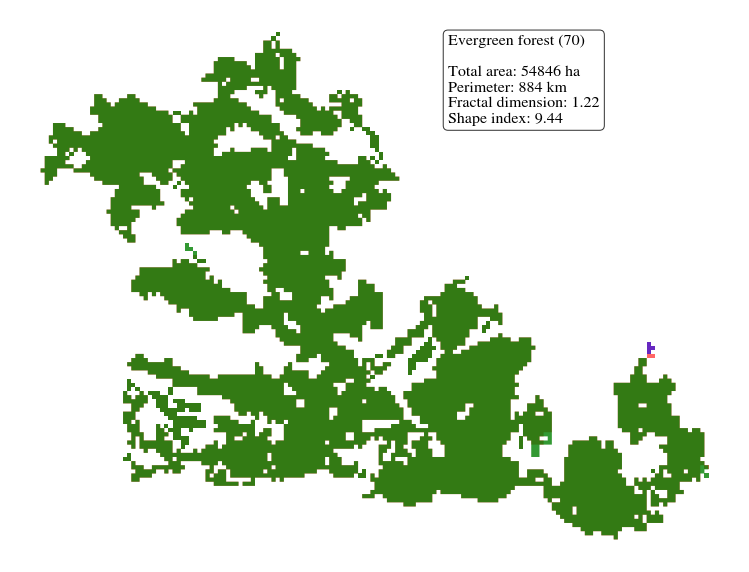

In [13]:
fig, ax = plt.subplots(1)
plot_scale_factor=2
set_dim(fig, fraction_of_line_width=plot_scale_factor)

cez_timeline[2013].df.loc[1629:1629].plot(ax=ax, color="red", alpha=0.6)
cez_timeline[2014].df.loc[1187:1187].plot(ax=ax, color="blue", alpha=0.6)
cez_timeline[2014].df.loc[1625:1625].plot(ax=ax, color="green", alpha=0.8)

inset_text = (
              f"Evergreen forest (70)\n\n"
              f"Total area: {graph.df.area.loc[1625]/1e4:.0f} ha\n"
              f"Perimeter: {graph.df.perimeter.loc[1625]/1e3:.0f} km\n"
              f"Fractal dimension: {graph.df.fractal_dimension.loc[1625]:.2f}\n"
              f"Shape index: {graph.df.shape_index.loc[1625]:.2f}"
             
             )

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# place a text box in upper left in axes coords
ax.text(0.6, 0.95, inset_text, transform=ax.transAxes, fontsize=8*plot_scale_factor,
        verticalalignment='top', bbox=props)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig("CEZ-nodediff-example.svg")
plt.savefig("CEZ-nodediff-example.pdf")